# **Bamboo mapping using the trained UNet models**

This demo illustrates the workflow for bamboo mapping using UNet-based semantic segmentation models trained on remote sensing imagery. The models are applied to perform inference on image data for bamboo mapping. The supported input data sources include:

- RGB imagery

- Canopy Height Model (CHM)

- Fusion of RGB and CHM data

The demo focuses on image-based segmentation workflows and does not directly process raw point cloud data.


#### Contact Information

Prof. Chinsu Lin: chinsu@mail.ncyu.edu.tw

Prof. Wenzhi Liao: wenzhi.liao@ugent.be

In [4]:
import torch
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading import BasicDataset
from unet import UNet
from skimage.io import imread,imsave, imshow
import rasterio
import matplotlib.pyplot as plt
from skimage.color import label2rgb

def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    return mask[0].long().squeeze().numpy()


### configure the parameters to load the models

In [5]:
mode = 'RGB'
# mode = 'CHM'
# mode = 'Fusion'

In [6]:
if mode == "RGB":
    n_channels=3 
elif mode == "CHM":
    n_channels=1
else:
    n_channels=4

In [7]:
net = UNet(n_channels=n_channels, n_classes=2, bilinear=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device=device)
# state_dict = torch.load('checkpoints/checkpoint_epoch100.pth', map_location=device)
state_dict = torch.load('models/model_RGB_2annotation.pth', map_location=device)

mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)


<All keys matched successfully>

### test the model

In [8]:
if mode == "RGB":
  orig_raster_file = 'data/CS43Bamboo_RGB.tif'
  img = imread(orig_raster_file)
elif mode == "CHM":
  orig_raster_file = 'data/CS43Bamboo_CHM.tif'
  img = imread(orig_raster_file)
  # img = np.uint8(255*(img - img.min())/(img.max()-img.min()))

else:
  orig_raster_file = 'data/CS43Bamboo_RGB.tif'
  img = imread(orig_raster_file)
  orig_raster_file = 'data/CS43Bamboo_CHM.tif'
  chm = imread(orig_raster_file)

C:\Users\USER\AppData\Local\Temp\ipykernel_40516\1327033090.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.uint8(img[10001:15000,10001:15000,:3]))


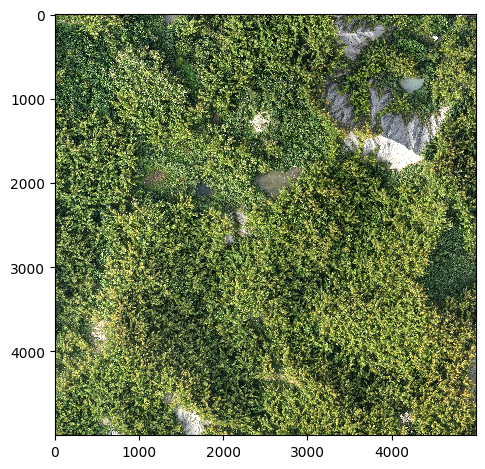

In [11]:
imshow(np.uint8(img[10001:15000,10001:15000,:3]))

In [13]:
def save_to_raster(orig_raster_file, input_img, output_tif_name, dtype):
    im = rasterio.open(orig_raster_file)
    print("transform: ", im.transform,im.crs)
    out_meta = im.meta.copy()
    # Edit your metadata like a dictionary in python:
    out_meta.update({'driver':'GTiff',
                     'width':im.shape[1],
                     'height':im.shape[0],
                     'count':1,
                     'dtype':dtype,
                     'crs':im.crs,
                     'transform':im.transform,
                     'nodata':0})
    # you have two options to save the index in format Geotiff using rasterio:


    with rasterio.open(fp=output_tif_name, #outputpath_name
                       mode='w',**out_meta) as dst:
                       dst.write(input_img,1) # the numer one is the number of bands

def save_to_raster_multiband(orig_raster_file, input_img, output_tif_name):

    # Read metadata of first file
    with rasterio.open(orig_raster_file) as src0:
        meta = src0.meta

    bands = input_img.shape[2]
    # Update meta to reflect the number of layers
    meta.update(count = bands)

    # Read each layer and write it to stack
    with rasterio.open(output_tif_name, 'w', **meta) as dst:
        for id in range(bands):
            dst.write_band(id+1, input_img[:,:,id])

In [14]:
def start_points(size, split_size, overlap=0):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            if split_size == size:
                break
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points



In [15]:
def patch_predict(img, net, patch_size, percent_overlap):

    if len(img.shape)>2:
        rows, cols, bands = img.shape
    else:

        rows, cols = img.shape
        bands = 1

    clf_img = np.zeros([rows, cols])
    X_points = start_points(cols, patch_size, percent_overlap)
    Y_points = start_points(rows, patch_size, percent_overlap)
    mask_values = state_dict.pop('mask_values', [0, 1])
    gap = int(patch_size * percent_overlap/2)
    c = 0
    for i in Y_points:
        for j in X_points:

            # if CHM, then normalize the patch to [0,255]
            if len(img.shape)>2:
                temp = img[i:i+patch_size, j:j+patch_size,:]
            else:
                temp = img[i:i+patch_size, j:j+patch_size]
                # temp = 255*(temp - temp.min())/(temp.max()-temp.min())

            patch_img = Image.fromarray(temp)#np.uint8(temp))

            split = predict_img(net=net,
                        full_img=patch_img,
                        scale_factor=0.5,
                        out_threshold=0.5,
                        device=device)

            if (i>1)&(j<2):
                clf_img[i+gap:i+patch_size, j:j+patch_size] = split[gap:,:]
                # New_img[i+gap:i+patch_size, j:j+patch_size,:] = label2rgb(split[gap:,:], colors = colors)
            elif (i<2)&(j>1):
                clf_img[i:i+patch_size, j+gap:j+patch_size] = split[:,gap:]
                # New_img[i:i+patch_size, j+gap:j+patch_size,:] = label2rgb(split[:,gap:], colors = colors)
            elif (i>1)&(j>1):
                clf_img[i+gap:i+patch_size, j+gap:j+patch_size] = split[gap:,gap:]
                # New_img[i+gap:i+patch_size, j+gap:j+patch_size,:] = label2rgb(split[gap:,gap:], colors = colors)
            else:
                clf_img[i:i+patch_size, j:j+patch_size] = split
                # New_img[i:i+patch_size, j:j+patch_size,:] = label2rgb(split, colors = colors)

    return clf_img




def patch_predict2(img, chm, net, patch_size, percent_overlap):


    if len(img.shape)>2:
        rows, cols, bands = img.shape
    else:

        rows, cols = img.shape
        bands = 1

    clf_img = np.zeros([rows, cols])
    X_points = start_points(cols, patch_size, percent_overlap)
    Y_points = start_points(rows, patch_size, percent_overlap)
    gap = int(patch_size * percent_overlap/2)
    c = 0
    for i in Y_points:
        for j in X_points:
            ti_col = img[i:i+patch_size, j:j+patch_size,:]

            ti = chm[i:i+patch_size, j:j+patch_size]
            if ti.max() > 0:
                ti = 255*ti/ti.max()
            ti = np.uint8(ti)
            temp = np.dstack([ti_col, ti])


            patch_img = Image.fromarray(np.uint8(temp))

            split = predict_img(net=net,
                        full_img=patch_img,
                        scale_factor=0.5,
                        out_threshold=0.5,
                        device=device)

            if (i>1)&(j<2):
                clf_img[i+gap:i+patch_size, j:j+patch_size] = split[gap:,:]
                # New_img[i+gap:i+patch_size, j:j+patch_size,:] = label2rgb(split[gap:,:], colors = colors)
            elif (i<2)&(j>1):
                clf_img[i:i+patch_size, j+gap:j+patch_size] = split[:,gap:]
                # New_img[i:i+patch_size, j+gap:j+patch_size,:] = label2rgb(split[:,gap:], colors = colors)
            elif (i>1)&(j>1):
                clf_img[i+gap:i+patch_size, j+gap:j+patch_size] = split[gap:,gap:]
                # New_img[i+gap:i+patch_size, j+gap:j+patch_size,:] = label2rgb(split[gap:,gap:], colors = colors)
            else:
                clf_img[i:i+patch_size, j:j+patch_size] = split
                # New_img[i:i+patch_size, j:j+patch_size,:] = label2rgb(split, colors = colors)


    return clf_img

In [16]:
## the patch size and percentage of overlapping pixels: gap = int(patch_size * percent_overlap/2)
patch_size = 1024
percent_overlap = 0.5

In [18]:
%%time
if mode=="Fusion":
    new_img = patch_predict2(img, chm, net, patch_size, percent_overlap)
else:
    new_img = patch_predict(img, net, patch_size, percent_overlap)

C:\Users\USER\AppData\Local\Temp\ipykernel_40516\93092192.py:22: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))


CPU times: total: 18min 53s
Wall time: 5min 1s


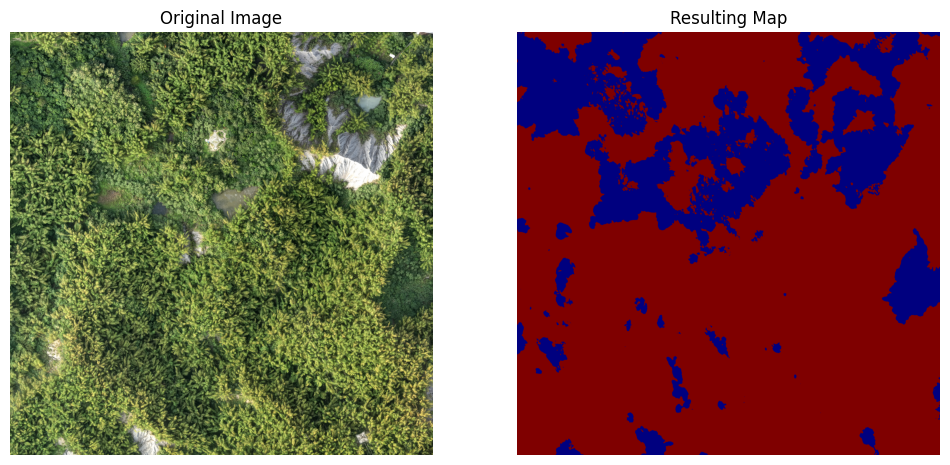

In [22]:
# Plot side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np.uint8(img[10001:15000,10001:15000,:3]))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(new_img[10001:15000,10001:15000], cmap='jet')  # Use a colormap for better visualization
plt.title("Resulting Map")
plt.axis('off')

plt.show()

In [ ]:
# imsave('results/temp.png',np.uint8(255*new_img))

### map all bamboo in the binary image and save the map

In [23]:
## save the segmentation result into tif including the geospatial information
dtype = 'uint8'
save_binary_map = 'results/RGBmodel_map.tif'
save_to_raster(orig_raster_file, np.uint8(255*new_img), save_binary_map, dtype)

transform:  | 0.10, 0.00, 191523.75|
| 0.00,-0.10, 2530077.55|
| 0.00, 0.00, 1.00| EPSG:3826


### map all bamboo in the color image and save the map

In [25]:
orig_raster_file = 'data/CS43Bamboo_RGB.tif'
img = imread(orig_raster_file)
save_RGB_map = 'results/RGBmodel_RGB.tif'


In [26]:
result = img.copy()
result[new_img==0] = 0
result[new_img!=0] = img[new_img!=0]

In [27]:
save_to_raster_multiband(orig_raster_file, result, save_RGB_map)